# Run Dire Dawa SFINCS Model

## Overview
In this notebook, we will run the Dire Dawa SFINCS hydrodynamic model and visualize the results. The model simulates water surface elevations and flow dynamics in the Dire Dawa region.

## What is SFINCS
SFINCS is a super-fast open-source flood model developed at Deltares. It enables rapid simulation of storm surge, riverine (fluvial) flooding, rainfall-runoff (pluvial), and wave-driven flooding from national, regional to local scales. Designed to run in minutes instead of days, SFINCS supports scenario testing, operational forecasting, and climate adaptation planning worldwide.

**Read the paper introducing SFINCS here** [paper](https://www.sciencedirect.com/science/article/abs/pii/S0378383920304828?via%3Dihub)

## Learning Objectives
- Understand how to set up and run the Dire Dawa SFINCS model.
- Visualize and interpret the model results.

In [1]:
# imports
from pathlib import Path
import os
import matplotlib.pyplot as plt
from hydromt_sfincs import SfincsModel
import rasterio
import pandas as pd
import numpy as np
import xarray as xr
import shutil

ERROR 1: PROJ: proj_create_from_database: Open of /opt/miniforge3/envs/hydromt_sfincs/share/proj failed


In [2]:
# Copy the shared data to the local folder
src = Path("/data/shared/SFINCS_Dire_Dawa/")
dst = Path("./sfincs_dire_dawa/")

# Create destination folder if missing
dst.mkdir(parents=True, exist_ok=True)

# Copy everything inside src → dst
for item in src.iterdir():
    target = dst / item.name
    if item.is_dir():
        shutil.copytree(item, target, dirs_exist_ok=True)
    else:
        shutil.copy2(item, target)

print("Copied all data into ./data")

Copied all data into ./data


## Understanding the sfincs model

When making a [SFINCS model](https://sfincs.readthedocs.io/en/latest/example.html), you need to create multiple input files. The model is driven via a main input file named sfincs.inp. This file references a variety of additional input files defining the domain, boundary conditions, topography/elevation, forcing, etc. Required inputs typically include: 
* elevation/topography (grid)
* mask or “active-cell” definitions
* boundary definitions

Optional inputs allow for more detailed configurations (roughness, infiltration, sub-grid tables, observation points). For forcing (i.e. what drives the flood), SFINCS supports various processes: 
* tidal / surge (water-level boundaries)
* rainfall, river discharge
* wind
* pressure
* waves

The model also supports structures human-made features like thin dams, levees (weirs), drainage infrastructure, which can block or divert flow. These are specified via specialized input files (e.g. thin-dam files, weir files) using polylines or geometry definitions. The model setup is supported by various tools. The easiest is the Python-based framework: [HydroMT-SFINCS](https://deltares.github.io/hydromt_sfincs/latest/index.html).

In [3]:
model_dir = r"sfincs_dire_dawa/"

### Input file

The input for SFINCS is supplied using various text (ascii), netcdf and binary files, which are linked through the main input file: sfincs.inp. 

In [4]:
with open(Path(model_dir) / "sfincs.inp") as f:
    print(f.read())

mmax                 = 820
nmax                 = 748
dx                   = 30
dy                   = 30
x0                   = 798015.0
y0                   = 1057663.0
rotation             = 0
epsg                 = 32637
latitude             = 0.0
tref                 = 20250401 000000
tstart               = 20250801 000000
tstop                = 20250804 000000
tspinup              = 60.0
dtout                = 3600.0
dthisout             = 600.0
dtrstout             = 604800
dtmaxout             = 86400
trstout              = -999
dtwnd                = 1800.0
alpha                = 0.5
theta                = 1.0
huthresh             = 0.01
manning              = 0.04
manning_land         = 0.04
manning_sea          = 0.02
rgh_lev_land         = 0.0
zsini                = 0.0
qinf                 = 1
rhoa                 = 1.25
rhow                 = 1024.0
dtmax                = 60.0
advection            = 1
baro                 = 0
pavbnd               = 0
gapres               

### src file

A simple implementation of discharge points is added to SFINCS, specify values in m^3/s. First specify the locations in ‘sfincs.src’ and then the discharge time-series in ‘sfincs.dis’. Alternatively, you can provide this as netcdf file in the Delft-FEWS format.

The discharge file should be in the following format:
```bash
<src1 x1> <src1 y1>

<src2 x2> <src2 y2>
```

In [5]:
with open(Path(model_dir) / "sfincs.src") as f:
    print(f.read())

816488.3 1059199.0
820720.7 1060811.1
801345.7 1065497.3
809973.1 1060939.0
805234.0 1062527.2
802348.1 1064209.0
812003.6 1059857.3



### Preicipitation forcing

In [6]:
import xarray as xr

ds = xr.open_dataset(Path(model_dir) / "precip_2d.nc")
ds

sh: 1: getfattr: not found


<xarray.Dataset> Size: 3MB
Dimensions:        (time: 3241, y: 10, x: 11)
Coordinates:
  * time           (time) datetime64[ns] 26kB 2025-04-01 ... 2025-08-14
  * y              (y) float64 80B 1.084e+06 1.081e+06 ... 1.057e+06 1.053e+06
  * x              (x) float64 88B 7.922e+05 7.957e+05 ... 8.236e+05 8.27e+05
    spatial_ref    int32 4B ...
Data variables:
    Precipitation  (time, y, x) float64 3MB ...

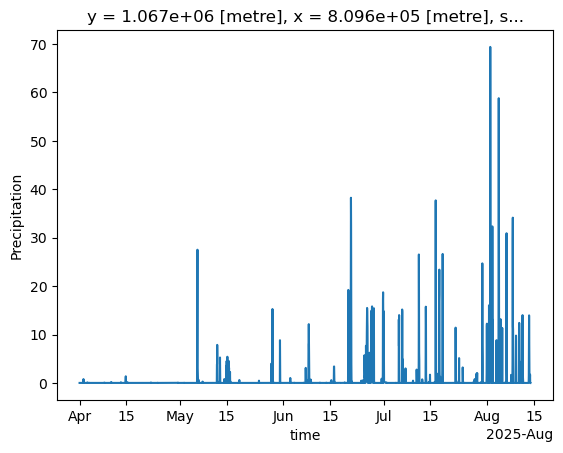

In [7]:
ds["Precipitation"].isel(x=5, y=5).plot()

### Grid

sh: 1: getfattr: not found


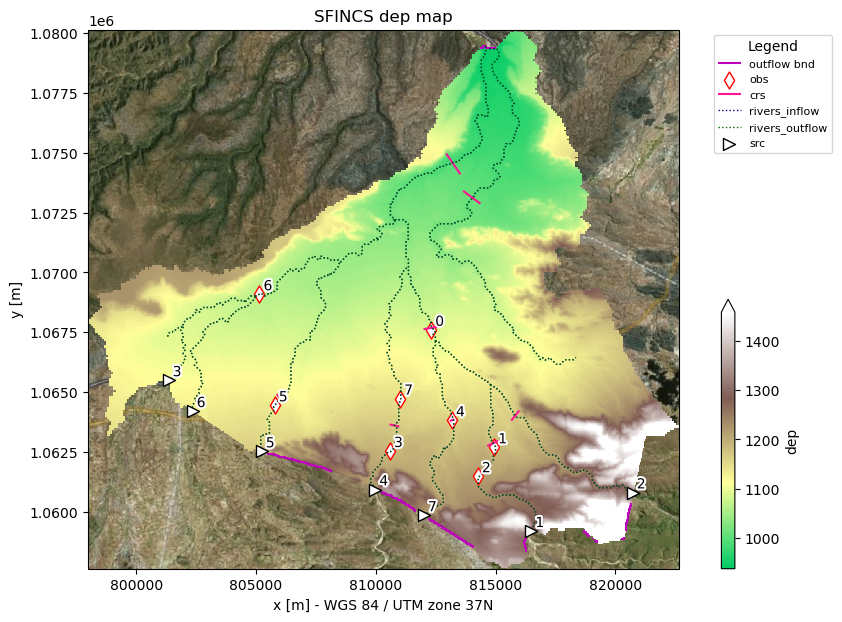

In [8]:
mod = SfincsModel(model_dir, mode="r")

# plot the model layout
fig, ax = mod.plot_basemap(fn_out=None, bmap="sat", figsize=(11, 7))

## Running a SFINCS model

SFINCS can be run on multiple different platforms, both local, HPC and cloud based. The simplest way is to run SFINCS on Windows using a batch-file. The windows executable can be downloaded from https://download.deltares.nl/sfincs. 

Here we installed SFINCS directly on the Ubuntu VM so everyone can run it without having to install it on your own laptop.

* Running the following cell will run the model!

⚠️ **Can take up to 15 minutes and takes a lot of computer resources**

In [ ]:
# ! cd {model_dir} && sfincs

Running is not required, we can look at the log file of output that was produced earlier

In [9]:
with open(Path(model_dir) / "sfincs_log.txt") as f:
    print(f.read())


------------ Welcome to SFINCS ------------

  @@@@@  @@@@@@@ @@ @@  @@   @@@@   @@@@@
 @@@ @@@ @@@@@@@ @@ @@@ @@ @@@@@@@ @@@ @@@
 @@@     @@      @@ @@@ @@ @@   @@ @@@
  @@@@@  @@@@@@  @@ @@@@@@ @@       @@@@@
     @@@ @@      @@ @@ @@@ @@   @@     @@@
 @@@ @@@ @@      @@ @@  @@  @@@@@@ @@@ @@@
  @@@@@  @@      @@ @@   @   @@@@   @@@@@

              ..............
          ......:@@@@@@@@:......
       ..::::..@@........@@.:::::..
     ..:::::..@@..::..::..@@.::::::..
    .::::::..@@............@@.:::::::.
   .::::::..@@..............@@.:::::::.
  .::::::::..@@............@@..::::::::.
 .:::::::::...@@.@..@@..@.@@..::::::::::.
 .:::::::::...:@@@..@@..@@@:..:::::::::..
 ............@@.@@..@@..@@.@@............
 ^^^~~^^~~^^@@..............@@^^^~^^^~~^^
 .::::::::::@@..............@@.:::::::::.
  .......:.@@.....@.....@....@@.:.......
   .::....@@......@.@@@.@....@@.....::.
    .:::~@@.:...:.@@...@@.:.:.@@~::::.
     .::~@@@@@@@@@@.....@@@@@@@@@~::.
       ..:~~~~~~~:.......:~~~~~~~:.

### Visualize Results
After running the model, we can visualize the results to analyze the water surface elevations and flow dynamics in the Dire Dawa region.


In [10]:
mod = SfincsModel(model_dir, mode="r")

In [11]:
# we can simply read the model results (sfincs_map.nc and sfincs_his.nc) using the read_results method
mod.read_results()
# the following variables have been found
list(mod.results.keys())

Grid type not known, trying to read from config file. 
depfile not found at /home/thomasstolp/Capacity-Building-ICPAC-for-climate-services/2_IBF_Flood_Damage/2_Hydrodynamic_Model/sfincs_dire_dawa/sfincs.dep
sh: 1: getfattr: not found
sh: 1: getfattr: not found
sh: 1: getfattr: not found
Replacing result: inp
Replacing result: msk
Replacing result: qinf
Replacing result: zb
Replacing result: zs
Replacing result: zsmax
Replacing result: cumprcp
Replacing result: cuminf
Replacing result: total_runtime
Replacing result: average_dt
Replacing result: status
sh: 1: getfattr: not found


['inp',
 'msk',
 'qinf',
 'zb',
 'zs',
 'zsmax',
 'cumprcp',
 'cuminf',
 'total_runtime',
 'average_dt',
 'status',
 'point_zb',
 'point_zs',
 'point_qinf',
 'crosssection_discharge']

### SFINCS Model Output Variables

#### Global Attributes

* **inp**: The full text of the sfincs.inp input file

* **status**: Numeric status code indicating whether the model completed successfully

* **total_runtime**: Total wall-clock runtime of the SFINCS simulation, in seconds

* **average_dt**: The average computational time step actually applied during the simulation, in seconds

#### Grid-Based Map Variables (from sfincs_map.nc)

* **zb**
Bed elevation (digital elevation model) on the SFINCS grid, in metres

* **zs**: Water surface elevation (stage) on the grid for each saved output time step, in metres

* **zsmax**: Maximum water level across the entire simulation for each cell

* **qinf**: Instantaneous infiltration or internal flux per grid cell, in m³/s (volumetric flow)

* **cumprcp**: Cumulative precipitation, integrated over time, typically expressed in metres of water

* **cuminf**: Cumulative infiltration, integrated over time, in metres

#### Point Time-Series Variables (from sfincs_his.nc)

* **point_zb**: Bed elevation at specified observation points

* **point_zs**: Time series of water level at defined observation points, in metres

* **point_qinf**: Time series of infiltration or internal flux at observation points


sh: 1: getfattr: not found


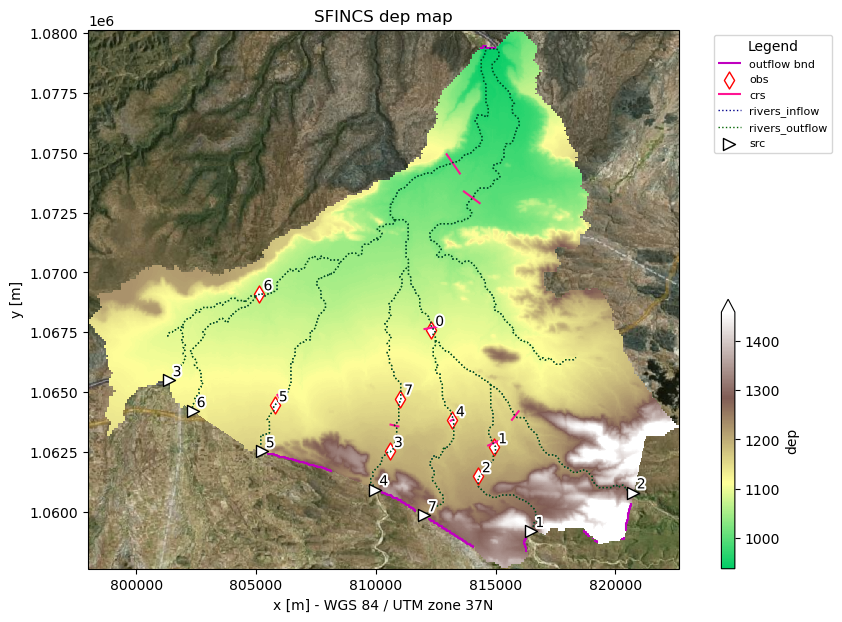

In [12]:
# plot the model layout
fig, ax = mod.plot_basemap(fn_out=None, bmap="sat", figsize=(11, 7))

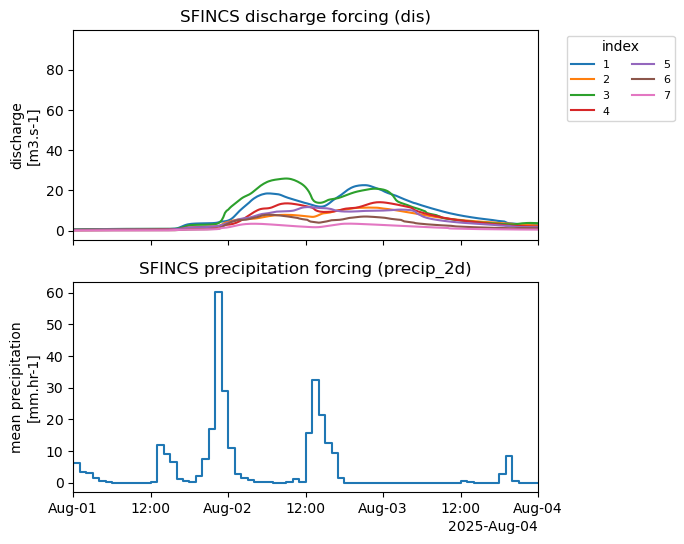

In [13]:
# Plot time-series:
_ = mod.plot_forcing(fn_out="forcing.png")

In [52]:
msk = ((mod.results['zsmax'].isel(timemax=2) - mod.results['zb']) > 0.05)
hmax = mod.results['zsmax'].max(dim='timemax')
dmax = hmax - mod.results['zb']

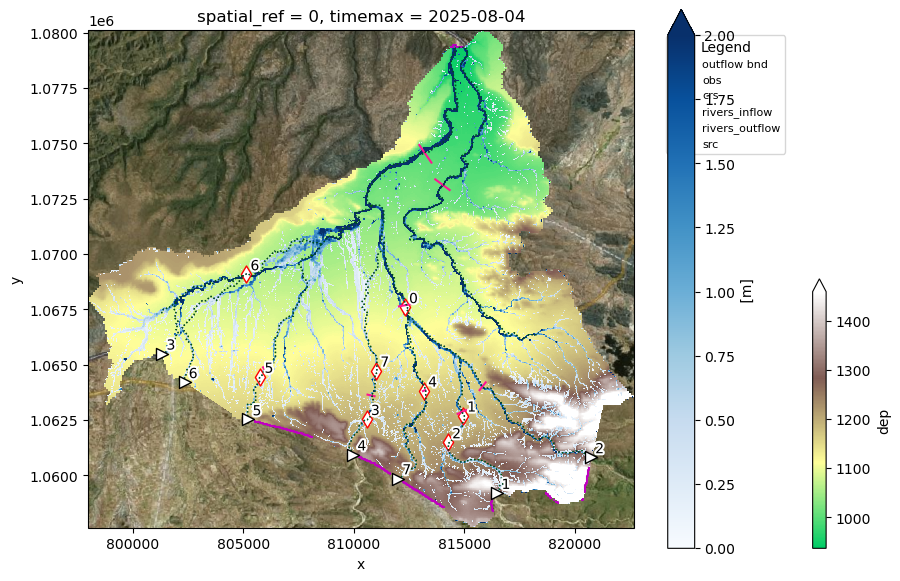

In [53]:
fig, ax = mod.plot_basemap(fn_out=None, bmap="sat", figsize=(11, 7))
dmax.where(msk).plot(ax=ax, cmap="Blues", vmin=0, vmax=2, zorder=1)

### Plot the timeseries in the cell with max waterdepth

Maximum water level location:
Latitude: 1065238.0
Longitude: 799650.0


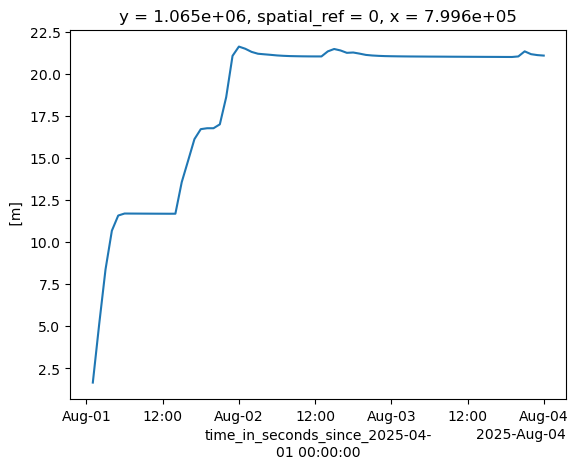

In [59]:
# Get the index of maximum water level
max_idx = dmax.where(msk).argmax()

# Convert flat index to 2D coordinates
max_coords = np.unravel_index(max_idx, dmax.shape)

# Get the actual lat/lon coordinates using .isel() for integer indexing
max_lat = d.y.isel(y=max_coords[0]).values
max_lon = d.x.isel(x=max_coords[1]).values

print(f"Maximum water level location:")
print(f"Latitude: {max_lat}")
print(f"Longitude: {max_lon}")

d.sel(x=max_lon, y=max_lat, method='nearest').plot()

### Save to tiff raster

In [60]:
xr.Dataset({"dmax" : dmax}).rio.to_raster("dmax.tif")

### Additional Resources

**Documentation**:
- HydroMT-SFINCS docs: https://deltares.github.io/hydromt_sfincs/
- SFINCS documentation: https://sfincs.readthedocs.io/
- HydroMT core: https://deltares.github.io/hydromt/